In [5]:
!python3 -V

Python 3.12.3


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
df = pd.read_parquet('../data/yellow_tripdata_2024-01.parquet')


In [7]:
df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.00
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.00
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.00
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.00
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.00
5,1,2024-01-01 00:54:08,2024-01-01 01:26:31,1.0,4.70,1.0,N,148,141,1,29.6,3.5,0.5,6.90,0.0,1.0,41.50,2.5,0.00
6,2,2024-01-01 00:49:44,2024-01-01 01:15:47,2.0,10.82,1.0,N,138,181,1,45.7,6.0,0.5,10.00,0.0,1.0,64.95,0.0,1.75
7,1,2024-01-01 00:30:40,2024-01-01 00:58:40,0.0,3.00,1.0,N,246,231,2,25.4,3.5,0.5,0.00,0.0,1.0,30.40,2.5,0.00
8,2,2024-01-01 00:26:01,2024-01-01 00:54:12,1.0,5.44,1.0,N,161,261,2,31.0,1.0,0.5,0.00,0.0,1.0,36.00,2.5,0.00
9,2,2024-01-01 00:28:08,2024-01-01 00:29:16,1.0,0.04,1.0,N,113,113,2,3.0,1.0,0.5,0.00,0.0,1.0,8.00,2.5,0.00


In [15]:
df.dtypes


VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
dtype: object

In [8]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime

In [9]:
#apply function
df.duration = df.duration.apply(lambda x : x.total_seconds()/60)


In [16]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [18]:
df.count()

VendorID                 81035
tpep_pickup_datetime     81035
tpep_dropoff_datetime    81035
passenger_count          81035
trip_distance            81035
RatecodeID               81035
store_and_fwd_flag       81035
PULocationID             81035
DOLocationID             81035
payment_type             81035
fare_amount              81035
extra                    81035
mta_tax                  81035
tip_amount               81035
tolls_amount             81035
improvement_surcharge    81035
total_amount             81035
congestion_surcharge     81035
Airport_fee              81035
duration                 81035
dtype: int64

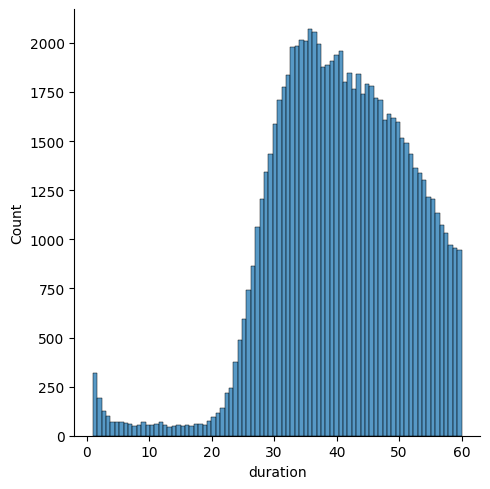

In [17]:
sns.displot(df.duration)


In [21]:
df.duration.describe(percentiles=[0.95,0.98,0.99])

count    81035.000000
mean        40.636044
std         10.680553
min          1.000000
50%         40.633333
95%         57.100000
98%         58.800000
99%         59.400000
max         60.000000
Name: duration, dtype: float64

In [26]:
df = pd.read_parquet('../data/green_tripdata_2024-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [27]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/Users/romakaul/Desktop/Akshay/workspace/MLOps/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.12641462014641

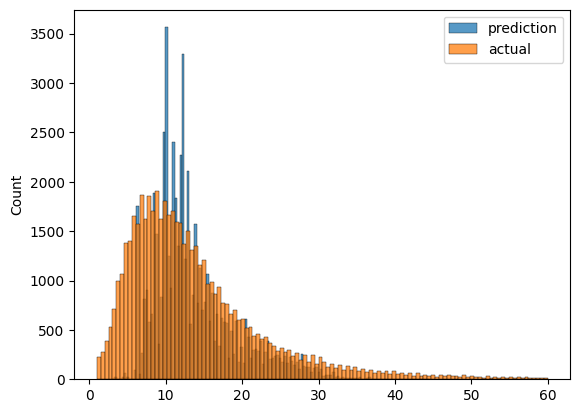

In [29]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()

In [30]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [35]:
df_train = read_dataframe('../data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2024-02.parquet')

In [36]:
len(df_train), len(df_val)

(54373, 51497)

In [37]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [38]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [39]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [40]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/Users/romakaul/Desktop/Akshay/workspace/MLOps/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


5.995446423639705

In [42]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [43]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/Users/romakaul/Desktop/Akshay/workspace/MLOps/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


8.029292935675121